# Практика сегментация

## Dataset

Мы будем использовать Oxford-IIIT Pet Dataset. Он состоит из 37 классов собак и кошек, на каждый класс около 200 картинок. В датасете есть как боксы и маски. В датасете около 7 тысяч изображений.  

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Скачаем данные и распакуем

In [1]:
%%capture out
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Заметим, у нас две папки в данных. Первая с `images` и вторая с разметкой масками как `binary` картинки.

## Импортируем нужные библиотеки

In [1]:
# %%capture out
!pip3 install albumentations torchmetrics pytorch_lightning -U

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached torchmetrics-0.11.4-py3-none-any.whl (519 kB)
     -------------------------------------- 829.5/829.5 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 12.1/12.1 MB 1.7 MB/s eta 0:00:00
  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-win_amd64.whl (38.1 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
     ---------------------------------------- 77.1/77.1 kB 2.1 MB/s eta 0:00:00
  Using cached fsspec-2023.1.0-py3-none-any.whl (143 kB)
  Using cached lightning_utilities-0.8.0-py3-none-any.whl (20 kB)
     -------------------------------------- 322.2/322.2 kB 1.3 MB/s eta 0:00:00
  Using cached scikit_learn-1.0.2-cp37-cp37m-win_amd64.whl (7.1 MB)
     ---------------------------------------- 3.4/3.4 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 1.5 MB/s eta 0:00:

In [17]:
# !pip3 install torch==1.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# !pip3 install setuptools==59.5.0

     -------------------------------------- 952.4/952.4 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0


In [1]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: otobuf is an invalid version and will not be supported in a future release
  warnings.warn(
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: nsorflow is an invalid version and will not be supported in a future release
  warnings.warn(
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: otobuf is an invalid version and will not be supported in a future release
  warnings.warn(
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: nsorflow is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
os.listdir()

['annotations',
 'coin.jpg',
 'images',
 'images.tar.gz',
 'Labelme.exe',
 'lightning_logs',
 'man_image.jpg',
 'man_image.json',
 'plate.jpg',
 'Segmentation_1.ipynb',
 'Segmentation_practice.ipynb']

## Готовим данные

Каждый пиксель изображения маски может принимать одно из трех значений: «1», «2» или «3». «1» означает, что данный пиксель изображения принадлежит классу «животное», «2» - классу «фон», «3» - классу «граница». Поскольку в этом примере демонстрируется задача двоичной сегментации (то есть присвоение одного из двух классов каждому пикселю), мы предварительно обработаем маску, поэтому она будет содержать только два уникальных значения: 0 если пиксель является фоном, и 1 если пиксель - это животное или граница.

In [3]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [4]:
class PetDataset(Dataset):
    def __init__(self, split="train", transform=None):
        images_train, images_test = train_test_split(
            os.listdir("images"), random_state=142, shuffle=True, train_size=0.8
        )
        if split == "train":
            self.images_filenames = images_train
        else:
            self.images_filenames = images_test

        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join("images", image_filename))
        if image is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(
                "annotations", "trimaps", image_filename.replace(".jpg", ".png")
            ),
            cv2.IMREAD_UNCHANGED,
        )
        if mask is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        mask = preprocess_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"] 
            mask = transformed["mask"]
        return image, mask

In [5]:
train_dataset = PetDataset()
val_dataset = PetDataset(split="val")

### Визуализация для проверки себя, аугментаций, данных

In [6]:
def display_few_examples_from_data(dataset, n=4):
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 24))
    for i in range(n):
        image, mask = dataset.__getitem__(i)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

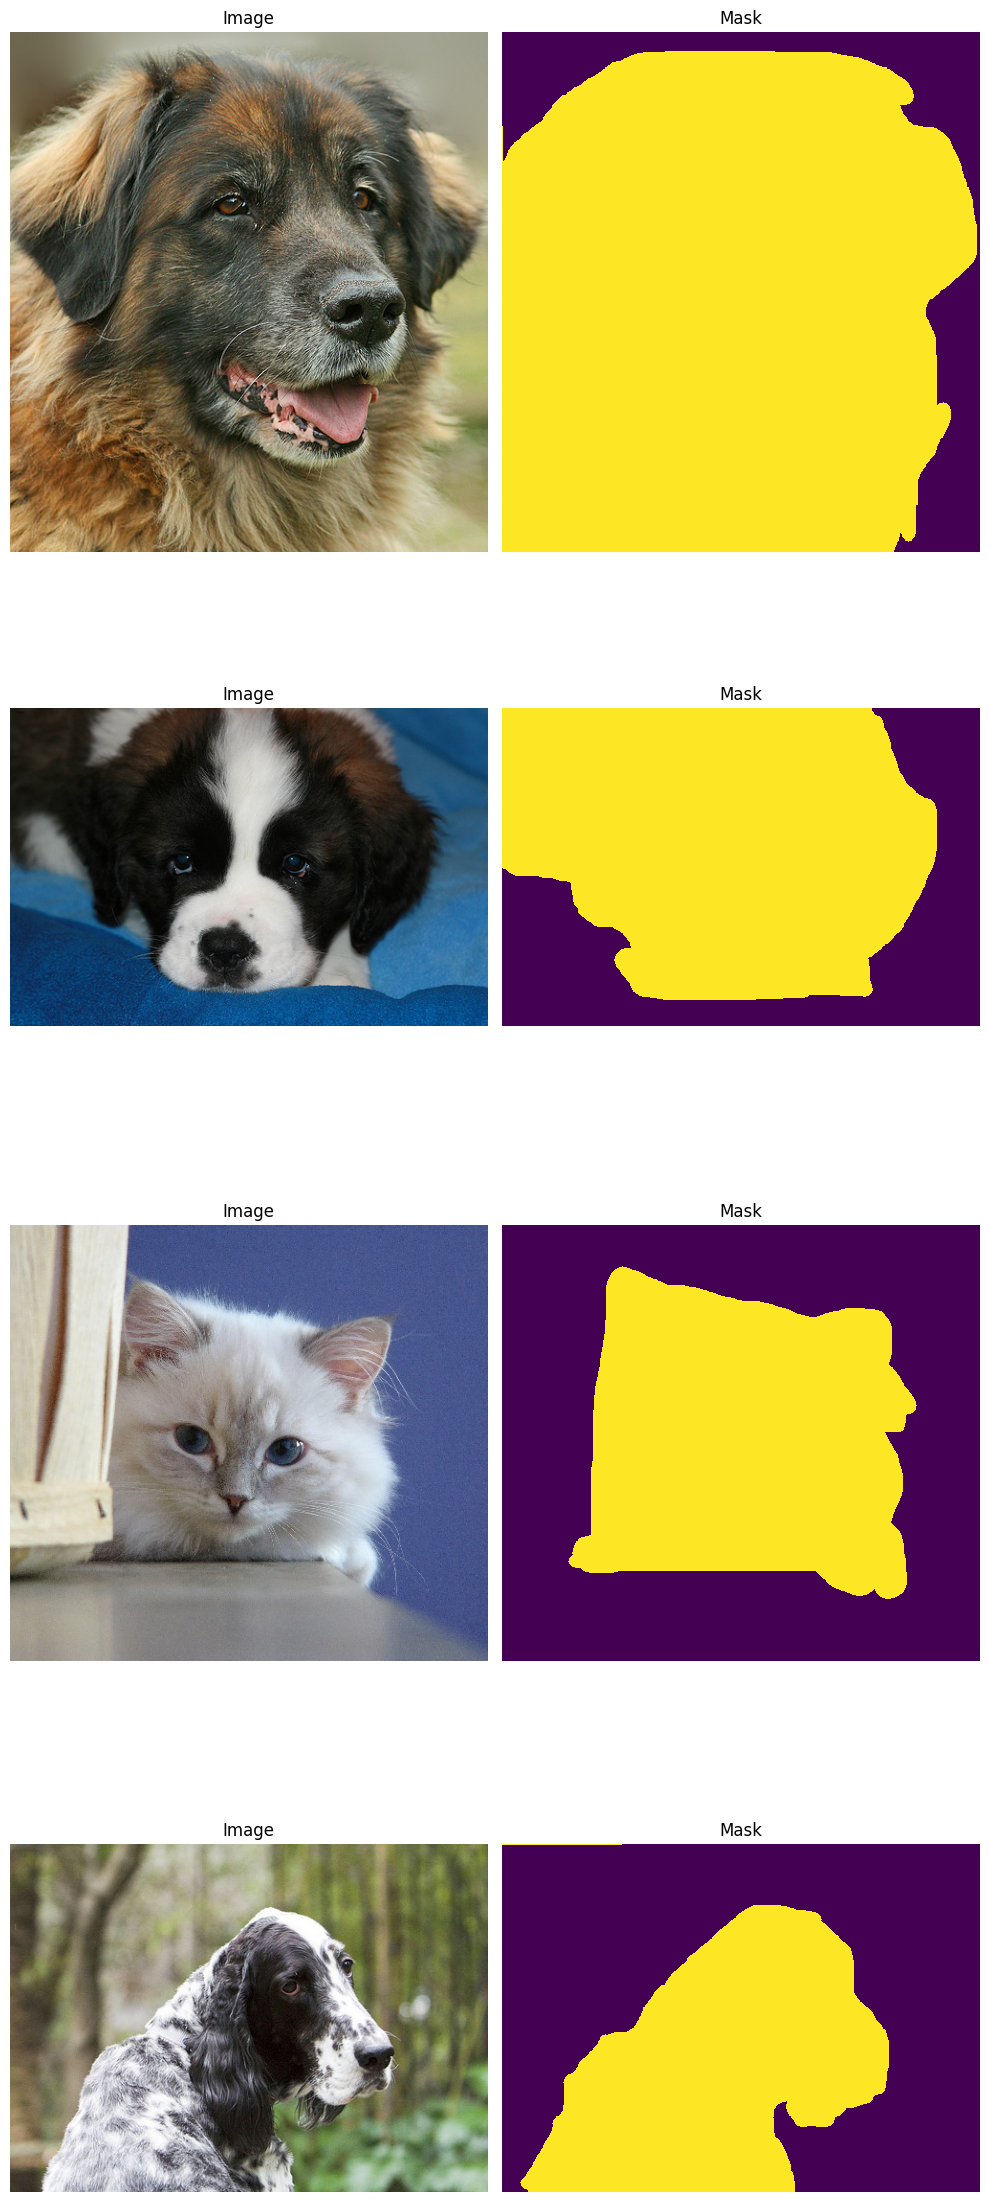

Validation dataset


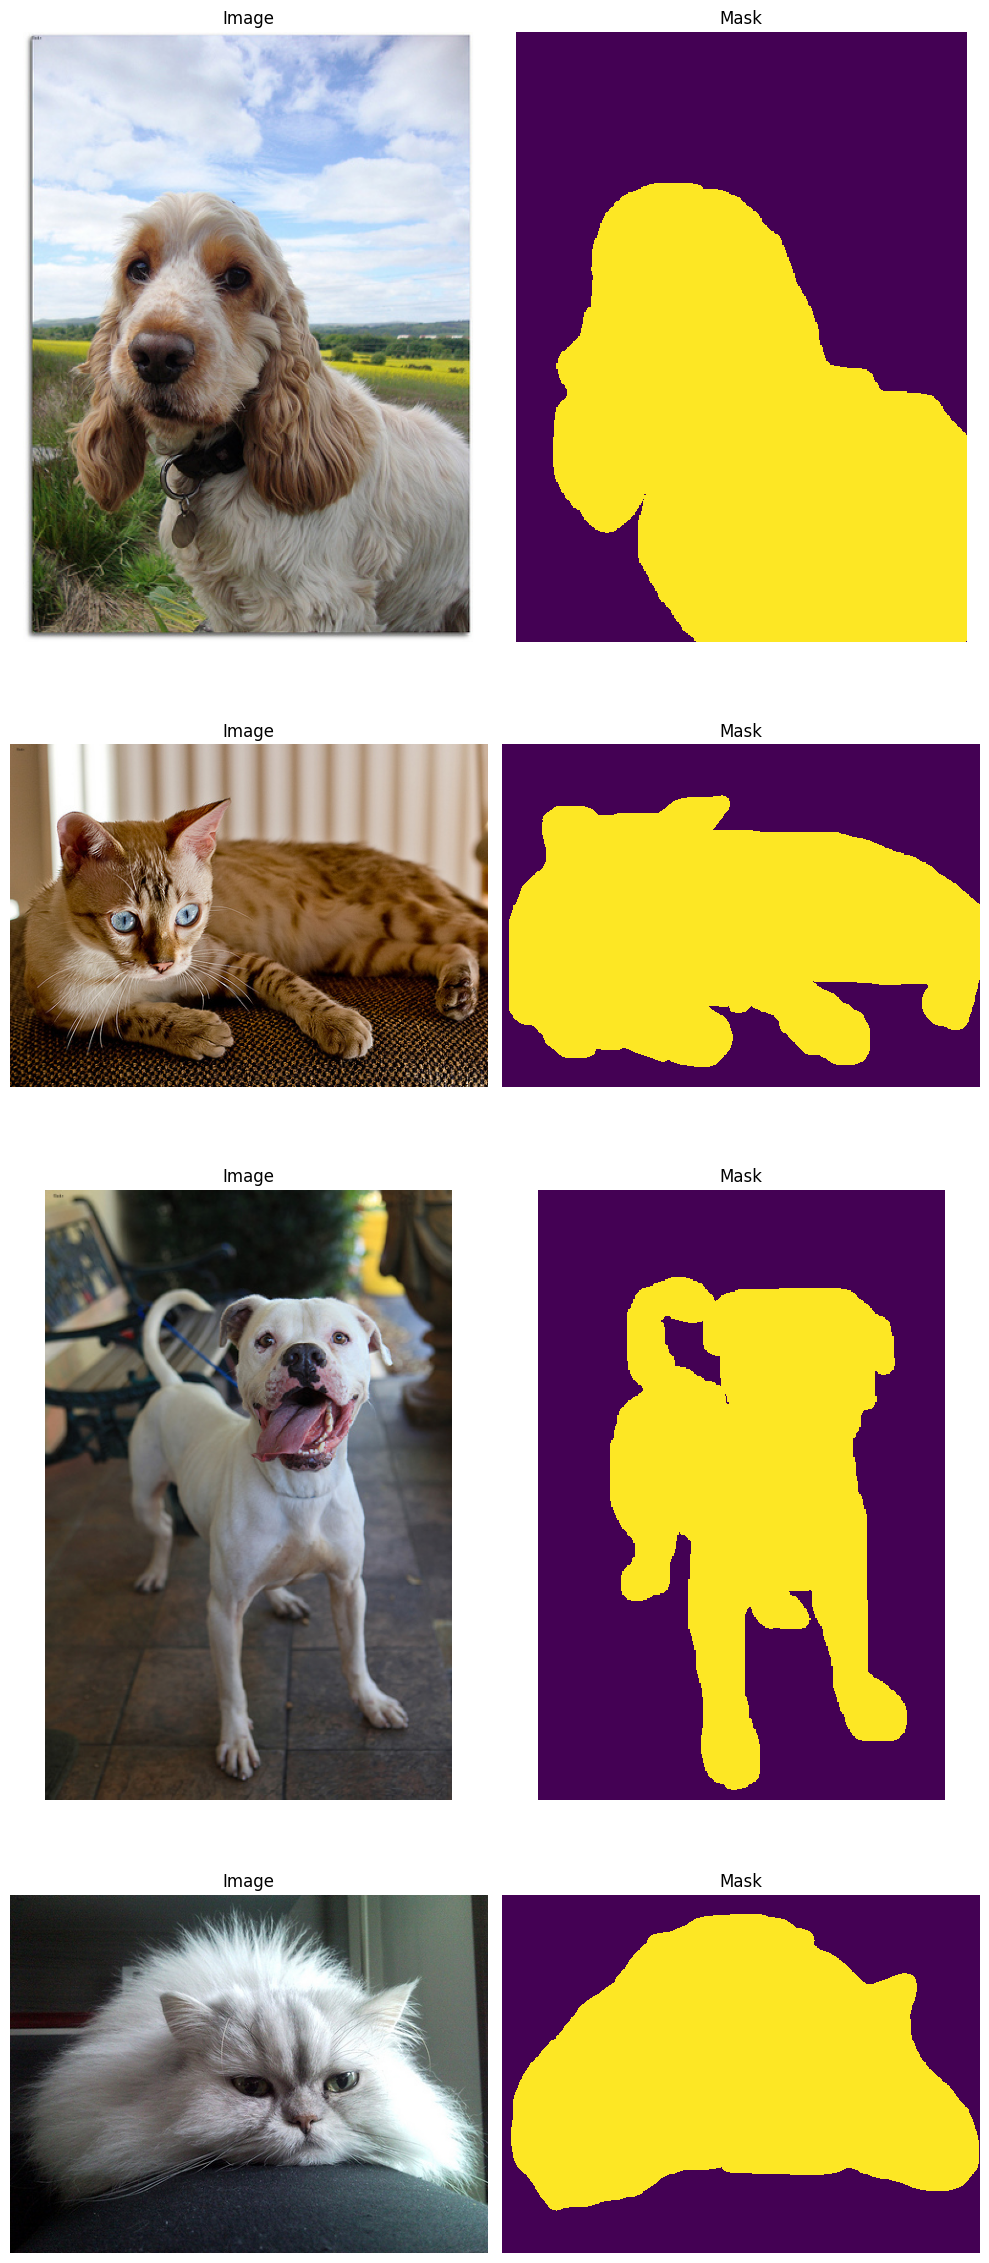

In [10]:
display_few_examples_from_data(train_dataset)
print("Validation dataset")
display_few_examples_from_data(val_dataset)

### Выбираем аугментации для обучения

In [7]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
     # Заполни своими
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # ToTensorV2(),
    ]
)
train_dataset = PetDataset(
    "train",
    transform=train_transform,
)

val_transform = A.Compose(
    [
        A.Resize(512, 512)
        # Заполни своими
    ]  # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = PetDataset("Val", transform=train_transform)

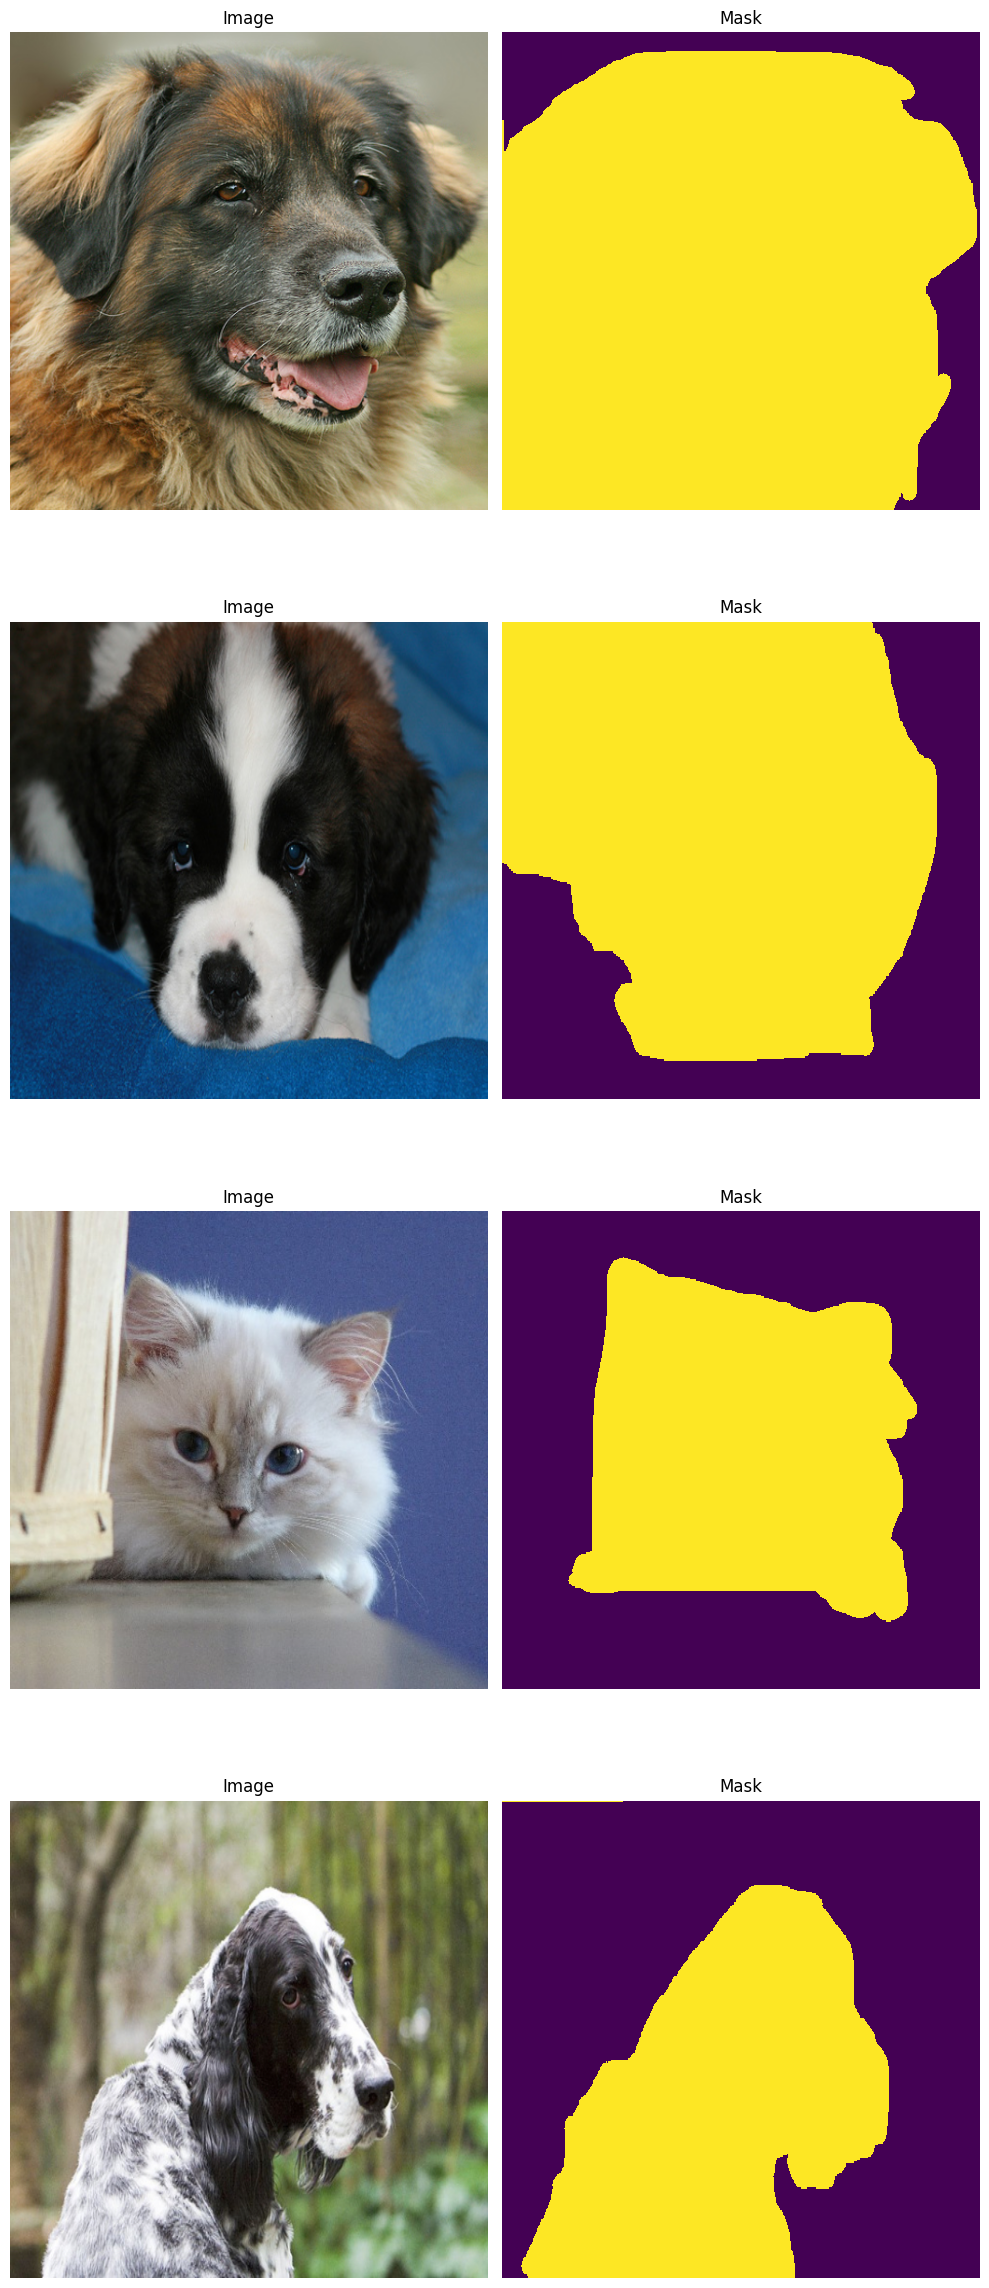

Validation dataset


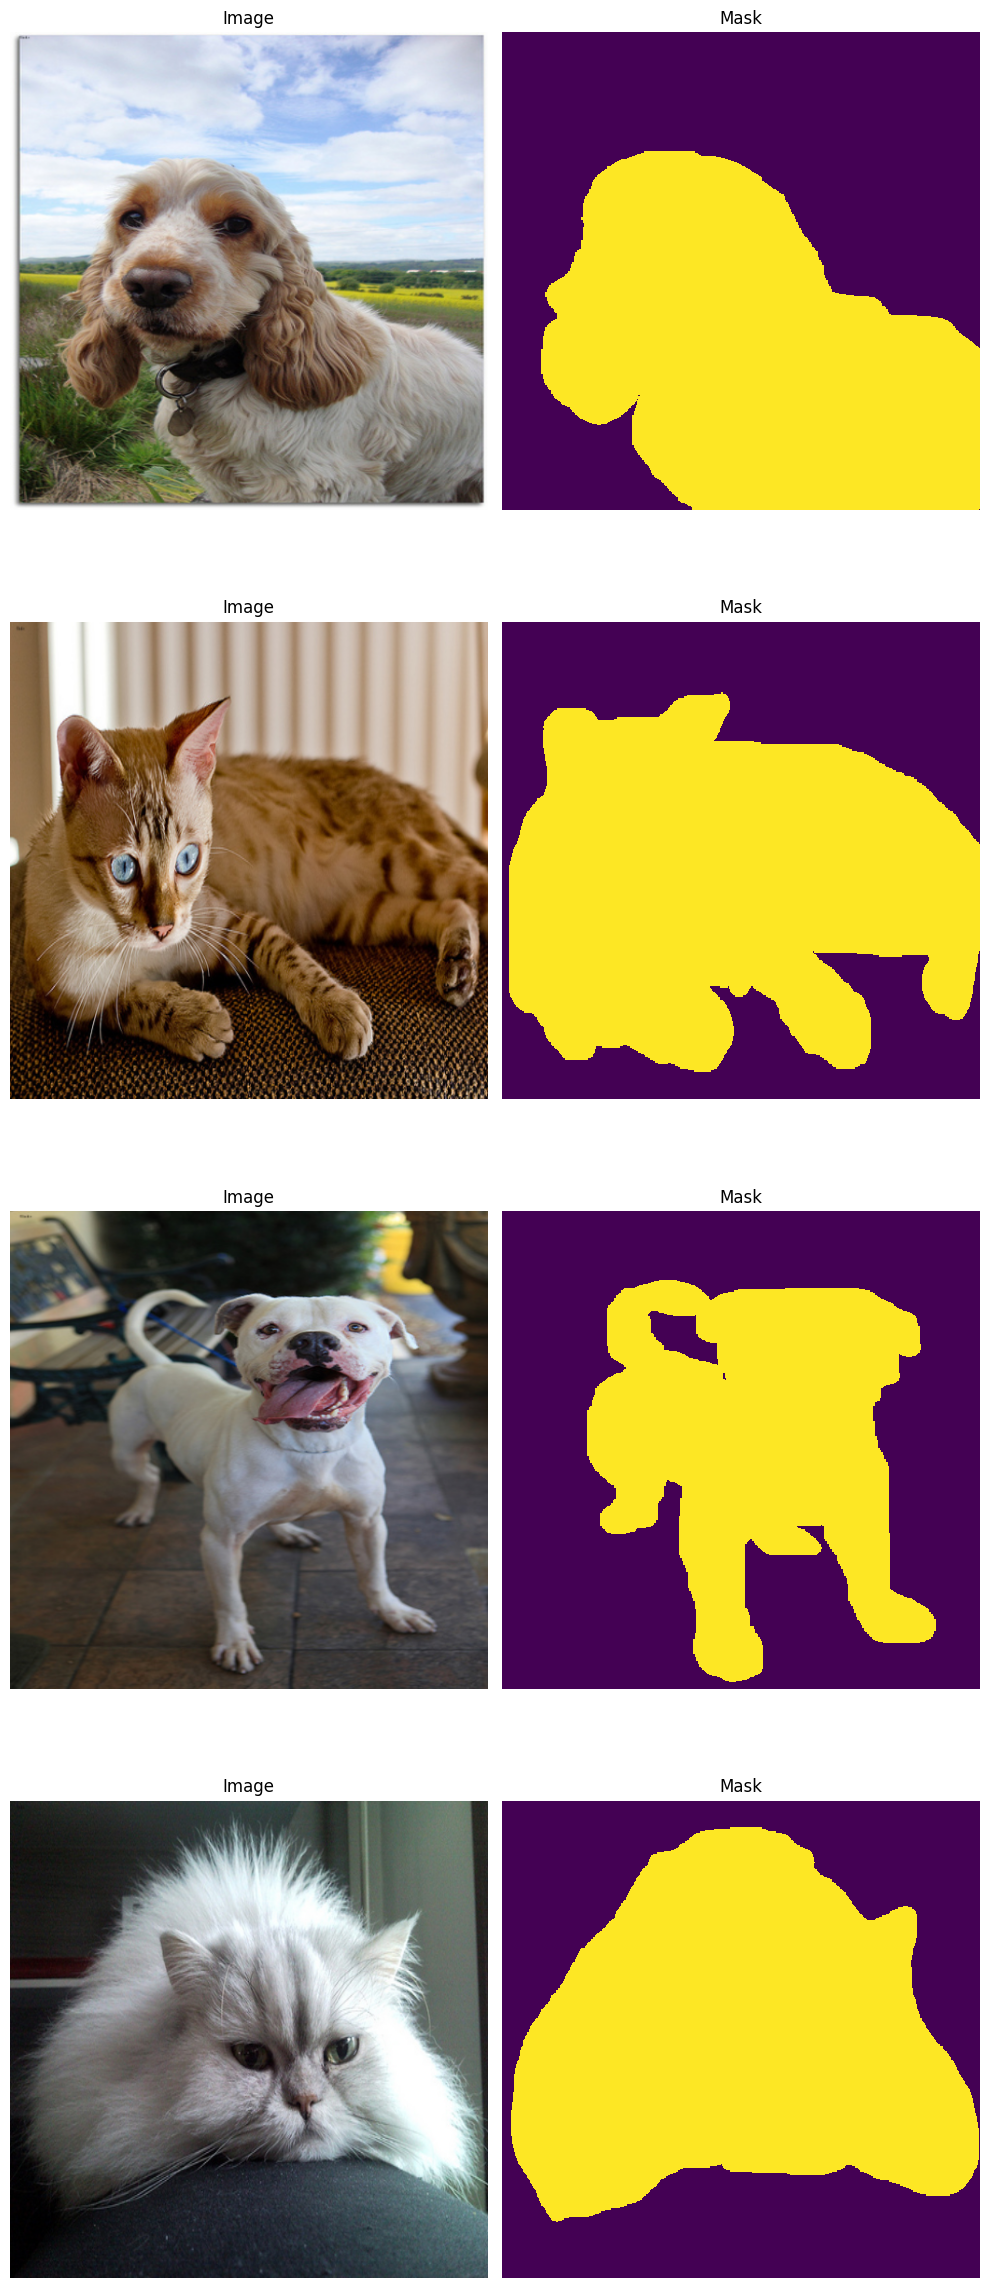

In [12]:
display_few_examples_from_data(train_dataset)
print("Validation dataset")
display_few_examples_from_data(val_dataset)

### После выбора аугментаций создаем датасеты для обучения.

In [8]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
     # Заполни своими
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = PetDataset(
    "train",
    transform=train_transform,
)

val_transform = A.Compose(
    [
        A.Resize(512, 512),
     # Заполни своими
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = PetDataset("Val", transform=train_transform)

## Модель и обучение

In [9]:
def IoU(preds, targs, eps: float = 1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]

    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)

    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)

    true_1_hot = true_1_hot.type(preds.type())

    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)  # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()  # find mean of class IoU values
    return iou

In [10]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [11]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [12]:
class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()
        self.batch_size = 4
        self.learning_rate = 1e-4
        # self.net = SomeModel(n_classes=1)
        self.net = UNet(n_channels=3, n_classes=1)

        self.trainset = train_dataset
        self.valset = val_dataset
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        out = self.forward(img) # [B, 1, H, W]
        loss_val = self.criterion(out.squeeze(1), mask) # [B, 1, H, W] -> # [B, H, W]
        iou_score = IoU(out.float(), mask.long())
        self.log("train_loss", loss_val)
        self.log("train_iou", iou_score, prog_bar=True)
        return loss_val

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.trainset, 
                          batch_size=self.batch_size, 
                          shuffle=True, prefetch_factor=2)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=1, shuffle=True)

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)
        loss_val = self.criterion(out.squeeze(1), mask)
        iou_score = IoU(out.float(), mask.long())
        self.log("val_loss", loss_val, prog_bar=True)
        self.log("val_iou", iou_score, prog_bar=True, on_epoch=True)

### Обучение

In [14]:
!nvidia-smi

Wed May  3 13:20:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.33       Driver Version: 528.33       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8     8W /  80W |    231MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
print(torch.cuda.is_available())

True


In [1]:
!pip3 list

Package                 Version
----------------------- ------------
absl-py                 0.15.0
aiohttp                 3.8.3
aiosignal               1.3.1
astor                   0.8.1
asttokens               2.0.5
astunparse              1.6.3
async-timeout           4.0.2
asyncio                 3.4.3
attrs                   22.2.0
backcall                0.2.0
beautifulsoup4          4.12.2
bleach                  6.0.0
blinker                 1.4
brotlipy                0.7.0
cachetools              4.2.2
certifi                 2022.12.7
cffi                    1.15.1
charset-normalizer      2.0.4
click                   8.0.4
colorama                0.4.6
comm                    0.1.2
conda                   23.1.0
conda-content-trust     0.1.3
conda-package-handling  2.0.2
conda_package_streaming 0.7.0
contourpy               1.0.6
cryptography            38.0.4
cycler                  0.11.0
Cython                  0.29.33
debugpy                 1.5.1
decorator           

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = SegModel(train_dataset, val_dataset)
model.to(device)

trainer = pl.Trainer(
    # gpus=1,
    # tpu_cores=1,
    devices=1, 
    accelerator='gpu',
    max_epochs=10,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_iou"),
        LearningRateMonitor("epoch"),
        EarlyStopping(monitor="val_iou", mode="max", patience=15),
    ],  # Log learning rate every epoch
    # progress_bar_refresh_rate=1,
)

trainer.fit(model)

d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: otobuf is an invalid version and will not be supported in a future release
  warnings.warn(
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: nsorflow is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | net       | UNet              | 17.3 M
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.070    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Валидация.
Результат ожидается тут.

In [19]:
trainer.validate(model, 
                 ckpt_path="./lightning_logs/version_1/checkpoints/epoch=9-step=14790.ckpt", dataloaders=model.val_dataloader())

Restoring states from the checkpoint path at ./lightning_logs/version_1/checkpoints/epoch=9-step=14790.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/version_1/checkpoints/epoch=9-step=14790.ckpt
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_iou             0.668102502822876
        val_loss            0.1721612811088562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.1721612811088562, 'val_iou': 0.668102502822876}]